## Quantifying synaptic variability with an adjusted coefficient of variation

Every time an action potential reaches an axon terminal, a random number of vesicles is released and the size of the resulting postsynaptic currents depends on the number of vesicles as well as many other factors (the state of receptors/ion channels, postsynaptic membrane potential, etc.). Thus synaptic strength is _stochastic_, varying from spike to spike. 

Some synapses are more or less stochastic than others, though, and we would like to be able to quantify this variability for each synapse. We have defined a metric for synaptic variability that is independent of the strength of the synapse (unlike variance) and is robust to biases from recording noise (unlike the coefficient of variation). 

In this notebook we'll explore and test these metrics.

In [16]:
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
import seaborn

First a function to simulate PSP amplitudes measured from a single synapse.

The true PSP amplitudes are log-normally distributed, but the recorded amplitudes also include gaussian noise.

PSP mean: 1.10, std: 0.49, noise std: 0.10


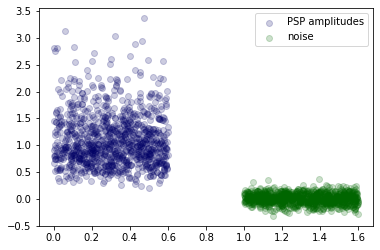

In [23]:
def simulate_synapse(mean, std, noise_std, n=1000):
    """Simulate a series of recorded PSP amplitudes with a given mean and standard deviation.
    """
    def lognorm_variance(sigma):
        return (np.exp(sigma**2) - 1) * np.exp(2 * np.log(mean) + sigma**2)
    sigma = scipy.optimize.fsolve(lambda sigma: std - lognorm_variance(sigma)**0.5, 0.5)[0]
    amps = np.random.lognormal(mean=np.log(mean), sigma=sigma, size=n)
    noise = np.random.normal(size=n, scale=noise_std)
    return amps + noise, noise

amps, noise = simulate_synapse(mean=1, std=0.5, noise_std=0.1)
print(f"PSP mean: {np.mean(amps):.2f}, std: {np.std(amps):.2f}, noise std: {np.std(noise):.2f}")


# swarm plot amplitudes and noise
fig, ax = plt.subplots()
# seaborn.swarmplot(data=[amps, noise], ax=ax)
ax.scatter(np.random.uniform(0, 0.6, len(amps)), amps, label='PSP amplitudes', color=(0, 0, 0.4, 0.2))
ax.scatter(np.random.uniform(1, 1.6, len(noise)), noise, label='noise', color=(0, 0.4, 0, 0.2))
ax.legend();

Primer: why don't we just use the standard deviation to measure synaptic variance?

Because we want a metric that tells us whether a synaptic connection is very reliable or not. However, the standard deviation is affected by the strength of a synapse _regardless_ of its reliability. 

In [37]:
# Simulate a synapse and scale its amplitudes, showing the effect on the standard deviation
print("Original PSP std:", np.std(amps))
print("STD after scaling by 2:", np.std(amps * 2))

Original PSP std: 0.50377570127075
STD after scaling by 2: 1.0075514025415


We want a measure of synaptic variance that is independent of strength, so that we could make statements like "cell type A makes very reliable synapses onto cell type B and highly variable synapses onto cell type C", without needing to address the question "ok, but is this just a trivial artifact of A->B synapses being weak and A->C synapses being strong?"

This is where the coefficient of variation is normaly used:

In [38]:
def cv(x):
    return np.std(x) / np.mean(x)

print("Original PSP CV:", cv(amps))
print("CV after scaling by 2:", cv(amps * 2))

Original PSP CV: 0.45683507037067406
CV after scaling by 2: 0.45683507037067406


Why don't we like using CV? Because for low-amplitude synapses, the CV becomes dominated by recording noise rather than synaptic variability. So we define an adjusted CV that attempts to correct for the effect of the noise floor:

In [46]:
def variability(x, noise_std):
    return (np.std(x)**2 - noise_std**2)**0.5 / abs(np.median(x))


/tmp/ipykernel_233664/122909778.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return (np.std(x)**2 - noise_std**2)**0.5 / abs(np.median(x))


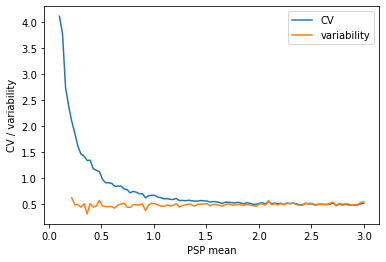

In [53]:
means = np.linspace(0.1, 3, 100)
noise_std = 0.5
results = [simulate_synapse(mean, std=0.5*mean, noise_std=noise_std, n=1000) for mean in means]
cvs = [cv(amps) for amps, noise in results]
vars = [variability(amps, noise_std) for amps, noise in results]

fig, ax = plt.subplots()
ax.plot(means, cvs, label='CV')
ax.plot(means, vars, label='variability')
ax.set_xlabel('PSP mean')
ax.set_ylabel('CV / variability')
ax.legend();

Above, we can see that whereas the CV becomes rapidly biased as the PSP mean approaches the noise floor at 0.5, variability remains unbiased by the noise (although it does become more unstable)